## Introduction






Welcome!

Injuries have become rampant in one of the biggest professional sports leagues in the United States: the NBA. However, not all injuries are the same. Some are simple and require a short recovery time, while others force players to miss months and alter the trajectories of their careers. Using data sourced from Kaggle, this notebook is going to explore this vast discrepancy in injury and ask key characteristic questions, such as:


*   What are the most common significant injuries? The least common?
*   Does injury frequency vary by position?
*   Which injuries have the greatest impact on in-game performance? The least?
*   Does injury impact vary by position?
*   How do these conclusions change given different classification methods?

And, finally, a prediction model will be created to estimate the impact of a certain injury on a player's performance.

This notebook will proceed in 4 stages:

1.   Data Cleaning and Joining

     Two datasets, containing player performance and injury data, will be cleaned and joined.

2.   Data Analysis

     The joined dataset will be used to make visualizations answering the above questions.

3.   Prediction Models

     A model to prediction the impact of an injury will be created and analyzed.

4.   Conclusion

     Final thoughts and takeaways will be explained.



Let's get started!



Before all, some necessary imports.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

The data being used comes from downloadable files -- let's set those up.

First, the performance data.

In [ ]:
url_performance = "https://drive.google.com/file/d/1ngjxz0n7cXOmRuj6We737OSregLkBbjz/view?usp=sharing"
path_performance = 'https://drive.google.com/uc?export=download&id='+url_performance.split('/')[-2]

df_perf = pd.read_csv(path_performance)
df_perf.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,17.1,3.3,8.8,...,0.2,1.0,1.2,1.9,0.5,0.0,0.6,1.0,7.3,1997-1998
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,16.3,2.4,6.1,...,0.7,1.2,2.0,0.9,0.6,0.2,1.1,1.4,6.4,1997-1998
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,36.0,8.0,16.4,...,2.8,4.3,7.1,2.6,1.1,0.9,3.1,2.5,22.3,1997-1998
3,4,Cory Alexander,PG,24,TOT,60,22,21.6,2.9,6.7,...,0.3,2.2,2.4,3.5,1.2,0.2,1.9,1.6,8.1,1997-1998
4,4,Cory Alexander,PG,24,SAS,37,3,13.5,1.6,3.9,...,0.2,1.1,1.3,1.9,0.7,0.1,1.3,1.4,4.5,1997-1998


Then, the injury data.

In [ ]:
url_injury = "https://drive.google.com/file/d/1cyzjX-sEsuGOtDZFrM588gDPltgiSyjR/view?usp=sharing"
path_injury = 'https://drive.google.com/uc?export=download&id='+url_injury.split('/')[-2]

df_injury = pd.read_csv(path_injury)
df_injury.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


Now, we're ready to begin cleaning and joining.



## Data Cleaning and Joining

The player performance data begins with the 1997-98 season and ends with the 2021-2022 season. However, the player injury data begins in 2010-11 and ends in 2019-2020. Thus, we only want a portion of the performance data.




In [ ]:
df_perf[df_perf["Year"] == "2010-2011"]
# 2010 - 2011 starts at index 6957
df_perf[df_perf["Year"] == "2020-2021"]
# 2019 - 2020 ends at index 13073

df_perf = df_perf.iloc[6957:13074]
df_perf.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
6957,1,Jeff Adrien,PF,24,GSW,23,0,8.5,1.0,2.3,...,1.0,1.5,2.5,0.4,0.2,0.2,0.4,1.2,2.5,2010-2011
6958,2,Arron Afflalo,SG,25,DEN,69,69,33.7,4.5,9.1,...,0.7,3.0,3.6,2.4,0.5,0.4,1.0,2.2,12.6,2010-2011
6959,3,Maurice Ager,SG,26,MIN,4,0,7.3,1.5,2.8,...,0.0,0.5,0.5,0.3,0.3,0.0,1.0,1.0,3.8,2010-2011
6960,4,Alexis Ajinça,C,22,TOT,34,2,10.0,1.7,3.9,...,0.5,1.8,2.3,0.3,0.3,0.6,0.5,2.1,4.2,2010-2011
6961,4,Alexis Ajinça,C,22,DAL,10,2,7.5,1.2,3.2,...,0.5,1.2,1.7,0.2,0.3,0.5,0.1,1.3,2.9,2010-2011


We're also only concerned with some metrics of player performance, not all.

In [ ]:
df_perf = df_perf[["Player", "Age", "Pos", "Tm", "G", "MP", "eFG%", "FT%", "TRB", "AST", "STL", "BLK", "TOV", "PTS", "Year"]]
df_perf.head()

,Player,Age,Pos,Tm,G,MP,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,Year
6957,Jeff Adrien,24,PF,GSW,23,8.5,0.426,0.579,2.5,0.4,0.2,0.2,0.4,2.5,2010-2011
6958,Arron Afflalo,25,SG,DEN,69,33.7,0.581,0.847,3.6,2.4,0.5,0.4,1.0,12.6,2010-2011
6959,Maurice Ager,26,SG,MIN,4,7.3,0.682,NaN,0.5,0.3,0.3,0.0,1.0,3.8,2010-2011
6960,Alexis Ajinça,22,C,TOT,34,10.0,0.489,0.722,2.3,0.3,0.3,0.6,0.5,4.2,2010-2011
6961,Alexis Ajinça,22,C,DAL,10,7.5,0.422,0.667,1.7,0.2,0.3,0.5,0.1,2.9,2010-2011


Speaking of metrics, it will be useful for this anaylsis to boil down player performance to a single statistic. There are numerous statistics that accomplish this feat, including the widely-used Player Efficiency Rating (PER). However, though these statistics are standard, they require data that is not included in our datasets. Thus, we have created our own statistic, called **Overall Performance (OP)**, to measure player performance. It is calculated thus:

*(POINTS x FG%) + [(ASSISTS + REBOUNDS) x FT%] + [(STEALS x BLOCKS) / (TURNOVERS + 1)]*

*NOTE*: justification of OP's validity is given in Note 1, which is located within the Notes section at the bottom of the notebook.

In [ ]:
df_perf["OP"] = (df_perf["PTS"] * df_perf["eFG%"]) + ((df_perf["AST"] + df_perf["TRB"]) * df_perf["FT%"]) + ((df_perf["STL"] * df_perf["BLK"]) / (df_perf["TOV"] + 1))
df_perf.head()

<ipython-input-6-17a077c01637>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf["OP"] = (df_perf["PTS"] * df_perf["eFG%"]) + ((df_perf["AST"] + df_perf["TRB"]) * df_perf["FT%"]) + ((df_perf["STL"] * df_perf["BLK"]) / (df_perf["TOV"] + 1))


,Player,Age,Pos,Tm,G,MP,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,Year,OP
6957,Jeff Adrien,24,PF,GSW,23,8.5,0.426,0.579,2.5,0.4,0.2,0.2,0.4,2.5,2010-2011,2.772671
6958,Arron Afflalo,25,SG,DEN,69,33.7,0.581,0.847,3.6,2.4,0.5,0.4,1.0,12.6,2010-2011,12.502600
6959,Maurice Ager,26,SG,MIN,4,7.3,0.682,NaN,0.5,0.3,0.3,0.0,1.0,3.8,2010-2011,NaN
6960,Alexis Ajinça,22,C,TOT,34,10.0,0.489,0.722,2.3,0.3,0.3,0.6,0.5,4.2,2010-2011,4.051000
6961,Alexis Ajinça,22,C,DAL,10,7.5,0.422,0.667,1.7,0.2,0.3,0.5,0.1,2.9,2010-2011,2.627464


Additionally, some of the names in the original data set contain asterisks. We'll remove those to keep names consistent between both datasets.

In [ ]:
def remove_ast(name: str):
  if (type(name) == str):
    if (name[-1] == "*"):
      return name[:-1]
  return name

df_perf["name"] = df_perf["Player"].map(remove_ast)

# drop old names
df_perf = df_perf.drop("Player", axis = 1)
df_perf.head()

,Age,Pos,Tm,G,MP,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,Year,OP,name
6957,24,PF,GSW,23,8.5,0.426,0.579,2.5,0.4,0.2,0.2,0.4,2.5,2010-2011,2.772671,Jeff Adrien
6958,25,SG,DEN,69,33.7,0.581,0.847,3.6,2.4,0.5,0.4,1.0,12.6,2010-2011,12.502600,Arron Afflalo
6959,26,SG,MIN,4,7.3,0.682,NaN,0.5,0.3,0.3,0.0,1.0,3.8,2010-2011,NaN,Maurice Ager
6960,22,C,TOT,34,10.0,0.489,0.722,2.3,0.3,0.3,0.6,0.5,4.2,2010-2011,4.051000,Alexis Ajinça
6961,22,C,DAL,10,7.5,0.422,0.667,1.7,0.2,0.3,0.5,0.1,2.9,2010-2011,2.627464,Alexis Ajinça


The injury data also needs to be cleaned. Since we are only concerned with injuries that impact that players' whole careers, we are only going to look at injuries that keep players on the sidelines for significant amounts of time. These injuries will have "out indefinitely" or "out for season" included in their entry.

In [ ]:
df_injury = df_injury[(df_injury["Notes"].str.contains("out indefinitely")) | (df_injury["Notes"].str.contains("out for season"))]
df_injury.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


This data will be easier to analyze if we differentiate between type of injury and length of absence.

In [ ]:
df_injury["injury"] = df_injury["Notes"].str.split("(").map(lambda x: x[0][:-1])

# string splitting doesn't indentify length consistenly,
# so use function instead
def injury_length(note):
  if "out indefinitely" in note:
    return "out indefinitely"
  return "out for season"

df_injury["length"] = df_injury["Notes"].apply(injury_length)

One of the names also begins with a space ... let's remove that.

In [ ]:
# one name also starts with space (in error)
def remove_space(name):
  if type(name) == str:
    if name[0] == " ":
      return name[1:]
  return name

df_injury["name"] = df_injury["Relinquished"].apply(remove_space)

Now we have:

In [ ]:
df_injury = df_injury[["Date", "Team", "name", "injury", "length"]]
df_injury.set_index("name")

df_injury.head()

,Date,Team,name,injury,length
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger,out indefinitely
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon,out indefinitely
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot,out indefinitely
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee,out indefinitely
4,2010-10-08,Nets,Troy Murphy,strained lower back,out indefinitely


However, notice that the injuries are listed with indivdiual datetimes. We want to convert these to their corresponding seasons.

*NOTE*: season start and end times sourced from Wikipedia. See Note 2.

In [ ]:
end_2010 = pd.to_datetime("06-12-2011")
end_2011 = pd.to_datetime("06-21-2012")
end_2012 = pd.to_datetime("06-20-2013")
end_2013 = pd.to_datetime("06-15-2014")
end_2014 = pd.to_datetime("06-16-2015")
end_2015 = pd.to_datetime("06-19-2016")
end_2016 = pd.to_datetime("06-12-2017")
end_2017 = pd.to_datetime("06-08-2018")
end_2018 = pd.to_datetime("06-13-2019")
end_2019 = pd.to_datetime("10-11-2020")

# convert date str to datetime
def date_to_season(date):
  date_time = pd.to_datetime(date)
  if date_time < end_2010:
    return "2010-2011"
  elif date_time < end_2011:
    return "2011-2012"
  elif date_time < end_2012:
    return "2012-2013"
  elif date_time < end_2013:
    return "2013-2014"
  elif date_time < end_2014:
    return "2014-2015"
  elif date_time < end_2015:
    return "2015-2016"
  elif date_time < end_2016:
    return "2016-2017"
  elif date_time < end_2017:
    return "2017-2018"
  elif date_time < end_2018:
    return "2018-2019"
  elif date_time < end_2019:
    return "2019-2020"
  # to catch errors
  else:
    return "N/A"

df_injury["Year"] = df_injury["Date"].map(date_to_season)
df_injury = df_injury[["name", "Year", "injury", "length"]]
df_injury.head()

,name,Year,injury,length
0,Carlos Boozer,2010-2011,fractured bone in right pinky finger,out indefinitely
1,Jonas Jerebko,2010-2011,torn right Achilles tendon,out indefinitely
2,Terrico White,2010-2011,broken fifth metatarsal in right foot,out indefinitely
3,Jeff Ayres,2010-2011,torn ACL in right knee,out indefinitely
4,Troy Murphy,2010-2011,strained lower back,out indefinitely


Furthermore, injuries need to categorized systematically in order to make statisitical analyses. Let's try some specific injury types.

In [ ]:
# don't want non-specific injuries
df_injury = df_injury[df_injury["injury"] != "placed on IL"]
df_injury = df_injury[df_injury["injury"] != "activated from IL"]

def categorize_injury(injury):
  if "Achilles" in injury:
    return "Achilles"
  if "ACL" in injury:
    return "ACL"
  elif "fibula" in injury:
    return "fibula"
  elif "tibia" in injury:
    return "tibia"
  elif "ankle" in injury:
    return "ankle"
  elif "shoulder" in injury:
    return "shoulder"
  elif "finger" in injury or "thumb" in injury or "hand" in injury:
    return "hand"
  elif "calf" in injury:
    return "calf"
  elif "wrist" in injury:
    return "wrist"
  elif "hip" in injury:
    return "hip"
  elif "back" in injury:
    return "back"
  elif "concussion" in injury:
    return "concussion"
  elif "elbow" in injury:
    return "elbow"
  elif "foot" in injury or "toe" in injury:
    return "foot"
  elif "COVID" in injury:
    return "COVID"
  elif "quad" in injury:
    return "quad"
  elif "groin" in injury:
    return "groin"
  elif "hernia" in injury:
    return "hernia"
  elif "hamstring" in injury:
    return "hamstring"
  elif "neck" in injury:
    return "neck"
  elif "heart" in injury:
    return "heart"
  elif "shin" in injury:
    return "shin"
  elif "spinal" in injury or "spine" in injury:
    return "spine"
  elif "pectoral" in injury:
    return "pec"
  elif "eye" in injury or "nose" in injury:
    return "face"
  elif "appendectomy" in injury:
    return "appendecotmy"
  elif "rib" in injury:
    return "rib"
  elif "abdominal" in injury:
    return "abdomen"
  elif "lung" in injury:
    return "lung"
  elif "appendicitis" in injury:
    return "appendicitis"
  elif "personal" in injury:
    return "personal"
  elif "undisclosed" in injury:
    return "undisclosed"
  elif "leg" in injury:
    return "leg"
  elif "knee" in injury:
    return "knee (non ACL)"
  else:
    return "misc."

df_injury["injury_type"] = df_injury["injury"].apply(categorize_injury)
df_injury.head()

,name,Year,injury,length,injury_type
0,Carlos Boozer,2010-2011,fractured bone in right pinky finger,out indefinitely,hand
1,Jonas Jerebko,2010-2011,torn right Achilles tendon,out indefinitely,Achilles
2,Terrico White,2010-2011,broken fifth metatarsal in right foot,out indefinitely,foot
3,Jeff Ayres,2010-2011,torn ACL in right knee,out indefinitely,ACL
4,Troy Murphy,2010-2011,strained lower back,out indefinitely,back


Finally, the injury and performance datasets can be joined.

In [ ]:
performance = df_perf.groupby(["name", "Year"]).last()
injuries = df_injury.groupby(["name", "Year"]).last()
joined = performance.join(injuries, how = 'outer', lsuffix='_left', rsuffix = '_right')

joined.head()

Age Pos   Tm     G    MP   eFG%    FT%  TRB  AST  \
name         Year                                                           
A.J. Hammons 2016-2017  24.0   C  DAL  22.0   7.4  0.464  0.450  1.6  0.2   
A.J. Price   2010-2011  24.0  PG  IND  50.0  15.9  0.420  0.667  1.4  2.2   
             2011-2012  25.0  PG  IND  44.0  12.9  0.414  0.800  1.4  2.0   
             2012-2013  26.0  PG  WAS  57.0  22.4  0.475  0.790  2.0  3.6   
             2013-2014  27.0  SG  MIN  28.0   3.5  0.478  0.000  0.4  0.5   

                        STL  BLK  TOV  PTS        OP injury length injury_type  
name         Year                                                               
A.J. Hammons 2016-2017  0.0  0.6  0.5  2.2  1.830800    NaN    NaN         NaN  
A.J. Price   2010-2011  0.6  0.0  1.1  6.5  5.131200    NaN    NaN         NaN  
             2011-2012  0.5  0.0  0.7  3.9  4.334600    NaN    NaN         NaN  
             2012-2013  0.6  0.1  1.1  7.7  8.110071    NaN    NaN         NaN  
             2013-2014  0.0  0.0  0.3  1.6  0.764800    NaN    NaN         NaN

**Wait!** Note that this joined Dataframe contains duplicates of injuries. For instance, the same ACL injury may be listed twice under "torn ACL" and "underwent surgery for torn ACL." This duplication is frequent but inconsistent, skewing the numbers within the analysis. Moreoever, a player enduring mutliple singificant injuries of the same type within one season is extremely unlikely. So, duplicates will be dropped.

In [ ]:
joined = joined.drop_duplicates()

joined.head()

Age Pos   Tm     G    MP   eFG%    FT%  TRB  AST  \
name         Year                                                           
A.J. Hammons 2016-2017  24.0   C  DAL  22.0   7.4  0.464  0.450  1.6  0.2   
A.J. Price   2010-2011  24.0  PG  IND  50.0  15.9  0.420  0.667  1.4  2.2   
             2011-2012  25.0  PG  IND  44.0  12.9  0.414  0.800  1.4  2.0   
             2012-2013  26.0  PG  WAS  57.0  22.4  0.475  0.790  2.0  3.6   
             2013-2014  27.0  SG  MIN  28.0   3.5  0.478  0.000  0.4  0.5   

                        STL  BLK  TOV  PTS        OP injury length injury_type  
name         Year                                                               
A.J. Hammons 2016-2017  0.0  0.6  0.5  2.2  1.830800    NaN    NaN         NaN  
A.J. Price   2010-2011  0.6  0.0  1.1  6.5  5.131200    NaN    NaN         NaN  
             2011-2012  0.5  0.0  0.7  3.9  4.334600    NaN    NaN         NaN  
             2012-2013  0.6  0.1  1.1  7.7  8.110071    NaN    NaN         NaN  
             2013-2014  0.0  0.0  0.3  1.6  0.764800    NaN    NaN         NaN

Now, we are ready for analysis.

## Data Analysis



**What are the most common significant injuries? The least common?**

Let's generate a visualization of the frequency of each injury. As you can see, knee injuries are by far the most common injury. Personal reasons are the least common.

<Axes: >

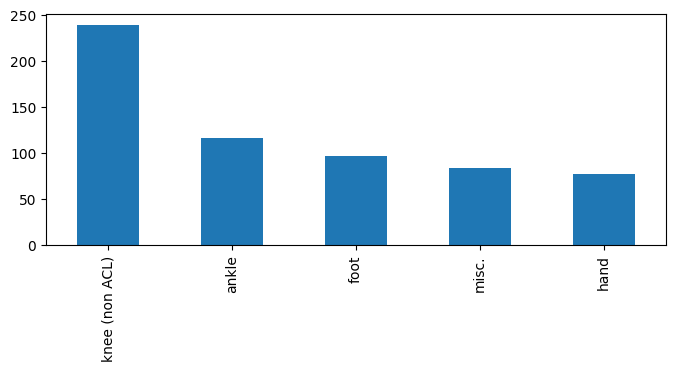

In [ ]:
joined["injury_type"].value_counts().nlargest(5).plot.bar(figsize = (8, 3))

<Axes: >

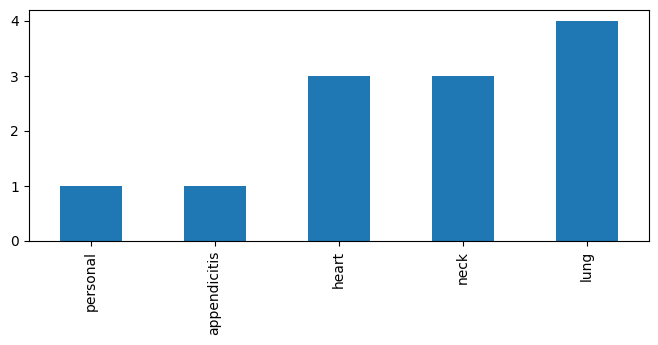

In [ ]:
joined["injury_type"].value_counts().nsmallest(5).plot.bar(figsize = (8, 3))

It is also worth noting that knee, ankle, and foot injuries dominate frequency across all positions.

In [ ]:
joined.groupby("Pos")["injury_type"].value_counts().groupby(level = 0).head(3)

Pos  injury_type   
C    knee (non ACL)    43
     ankle             20
     hand              14
PF   knee (non ACL)    38
     ankle             26
     foot              20
PG   knee (non ACL)    42
     foot              17
     hand              17
SF   knee (non ACL)    49
     foot              17
     ankle             14
SG   knee (non ACL)    32
     ankle             25
     hand              17
Name: injury_type, dtype: int64

**Does total injury frequency vary by position?**

Apparently not, as it appears that the number of injuries sustained by each position is roughly the same.

<Axes: xlabel='Pos'>

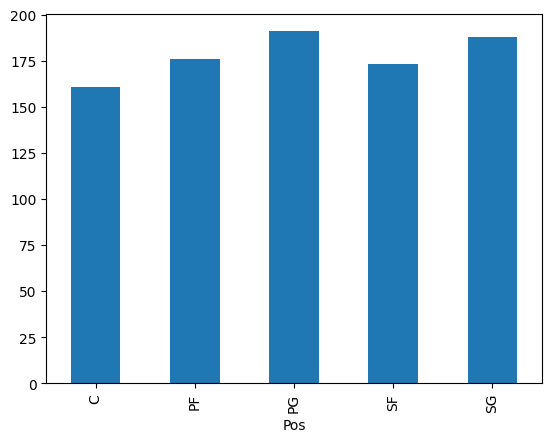

In [ ]:
joined.groupby("Pos")["injury_type"].count().plot.bar()

Now, the more interesting analysis comes with respect to the change in a player's performance after injury. In order to explore this phenomoenon, a player's "change" will be determined by subtracting the mean OP before injury from the mean OP after injury.

It could be argued that the change in OP *between* injuries should be compared instead of including other injuries within the comparison. We decided against the "between" method because the purpose of this analysis is to evaluate the *career-wide* implications of certain injuries. Looking at data points just between injuries removes the long-term consideration of injuries and allows for more year-to-year fluctuation, two possibilities that should be avoided.

In [ ]:
joined["change"] = np.nan

# find change in performance before and after injury
def find_change(joined, injured):
  # if injury occured in last year of dataset, want to ignore
  if injured[1] == "2019-2020" or injured[1] == "2010-2011":
    return(np.nan)

  play_before_injury = joined.loc[injured[0]]["OP"][:injured[1]].mean()
  play_year_of_and_after = joined.loc[injured[0]]["OP"][injured[1]:].sum(skipna=True)
  play_year_of = joined.loc[injured[0]]["OP"][injured[1]]
  years_after_injury = len(joined.loc[injured[0]]["OP"][injured[1]:]) - 1

  # still want to include change if injury ended player's career
  if years_after_injury == 0:
    return 0 - play_before_injury

  # if player missed an entire year, cannot subtract nan value
  if pd.isna(play_year_of):
    play_after_injury = play_year_of_and_after / years_after_injury
  else:
    play_after_injury = (play_year_of_and_after - play_year_of) / (years_after_injury)

  return(play_after_injury - play_before_injury)


injured_list = joined[~joined["injury"].isna()].index.unique()

# iterate through all injured players and find change in performance
for injured in injured_list:
  joined.at[injured, "change"] = find_change(joined, injured)

**Which injuries have the greatest impact on in-game performance? The least?**

According to our analysis, *rib injuries have the greatest effect on player performance*. This conclusion is quite surprising, at is is commonly believed that Achilles and ACL injuries have the greatest impact on a player's career.  

Two explanations could be offered here. First, it could be that, because there are very few rib, lung, and neck injuries, our conclusion is simply biased. Second, it could be that, though these injuries are uncommon, occurences significant enough to sideline a player for a prolonged period of time have incredible impact. It makes sense that a serious lung injury would prevent a player from ever performing at the same level, for instance.

It is our personal belief that this finding is due to a combination of the two of the explanations offered. While it is true that there are much fewer observations of rib than ACL injuries, the effects of these injuries on performance should not be dismissed. Thus, while the specific numerical result may be biased, a general conclusion that rib, lung, and neck injuries have the greatest effect on player performance could be drawn.

<Axes: xlabel='injury_type'>

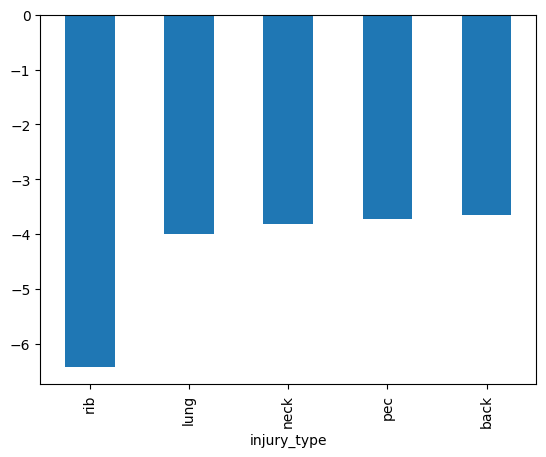

In [ ]:
joined.groupby("injury_type")["change"].mean().nsmallest(5).plot.bar()

On the other side of the spectrum, fibula injuries don't have any negative effect on playing ability. In fact, on average, players get even better after coming back from fibula injuries.

<Axes: xlabel='injury_type'>

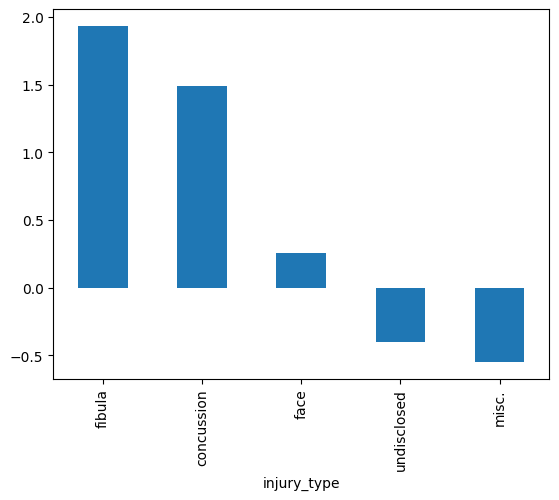

In [ ]:
joined.groupby("injury_type")["change"].mean().nlargest(5).plot.bar()

**Does injury impact vary by position?**

Yes. On average, power forwards are the most impacted by injuries, followed by centers, point guards, and small forwards (roughly the same), and then shooting guards.

<Axes: xlabel='Pos'>

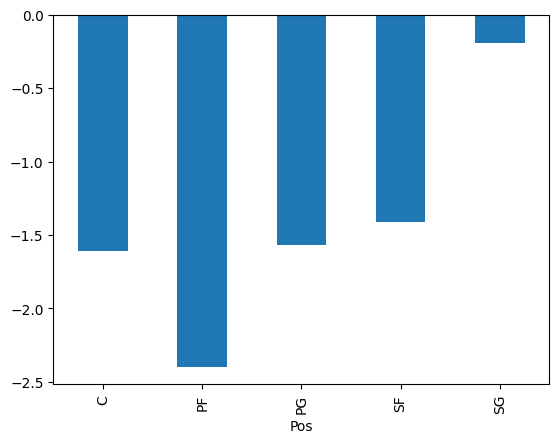

In [ ]:
joined.groupby("Pos")["change"].mean().plot.bar()

**How do these conclusions change given different classification methods?**

What happens if we classify injuries more generally? Do our results change?


In [ ]:
leg = ["Achilles", "fibula", "tibia", "ankle", "calf", "shin", "knee", "leg", "foot", "toe"]
upper_body = ["shoulder", "neck", "spine", "spinal", "pectoral", "rib", "abdominal", "lung", "back"]
lower_body = ["hip", "quad", "groin", "hamstring"]
arm = ["elbow", "finger", "thumb", "hand", "wrist"]
head = ["concussion", "eye", "nose", "face"]
medical = ["COVID", "appendectomy", "appendicitis", "hernia", "heart", "concussion"]

def broadly_categorize_injury(injury):
  if any(part in injury for part in leg):
    return "leg"
  elif any(part in injury for part in upper_body):
    return "upper_body"
  elif any(part in injury for part in lower_body):
    return "lower_body"
  elif any(part in injury for part in arm):
    return "arm"
  elif any(part in injury for part in head):
    return "head"
  elif any(part in injury for part in medical):
    return "medial"
  else:
    return "other"

df_injury["injury_type"] = df_injury["injury"].apply(broadly_categorize_injury)

In [ ]:
players = df_perf.groupby(["name", "Year"]).last()
injuries = df_injury.groupby(["name", "Year"]).last()
joined_broadly = players.join(injuries, how = 'outer', lsuffix='_left', rsuffix = '_right')

joined_broadly = joined_broadly.drop_duplicates()
joined_broadly.head()

Age Pos   Tm     G    MP   eFG%    FT%  TRB  AST  \
name         Year                                                           
A.J. Hammons 2016-2017  24.0   C  DAL  22.0   7.4  0.464  0.450  1.6  0.2   
A.J. Price   2010-2011  24.0  PG  IND  50.0  15.9  0.420  0.667  1.4  2.2   
             2011-2012  25.0  PG  IND  44.0  12.9  0.414  0.800  1.4  2.0   
             2012-2013  26.0  PG  WAS  57.0  22.4  0.475  0.790  2.0  3.6   
             2013-2014  27.0  SG  MIN  28.0   3.5  0.478  0.000  0.4  0.5   

                        STL  BLK  TOV  PTS        OP injury length injury_type  
name         Year                                                               
A.J. Hammons 2016-2017  0.0  0.6  0.5  2.2  1.830800    NaN    NaN         NaN  
A.J. Price   2010-2011  0.6  0.0  1.1  6.5  5.131200    NaN    NaN         NaN  
             2011-2012  0.5  0.0  0.7  3.9  4.334600    NaN    NaN         NaN  
             2012-2013  0.6  0.1  1.1  7.7  8.110071    NaN    NaN         NaN  
             2013-2014  0.0  0.0  0.3  1.6  0.764800    NaN    NaN         NaN

Answering our questions again, we come away with two points.

The first is that leg injuries are still the most common type of injury, occuring much more frequently than every other type.

<Axes: >

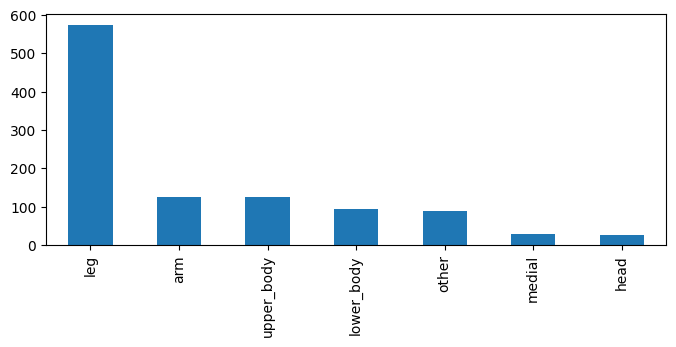

In [ ]:
joined_broadly["injury_type"].value_counts().nlargest(7).plot.bar(figsize = (8, 3))

In [ ]:
injured_list = joined_broadly[~joined_broadly["injury"].isna()].index.unique()

# go through all injured players and find change in performance
for injured in injured_list:
  joined_broadly.at[injured, "change"] = find_change(joined_broadly, injured)

The second is that upper body injuries (including rib, lung, and neck) *still have the greatest impact on player performance*. Though the relative difference in impact has decreased, the same kinds of injuries, overall, cause the greatest effects on player performace.

This evidence supports the validity of the previous conclusion. **Despite their small sample sizes, it is logical to conclude that rib, lung, and neck injuries have the greatest impact on player performace.**

<Axes: xlabel='injury_type'>

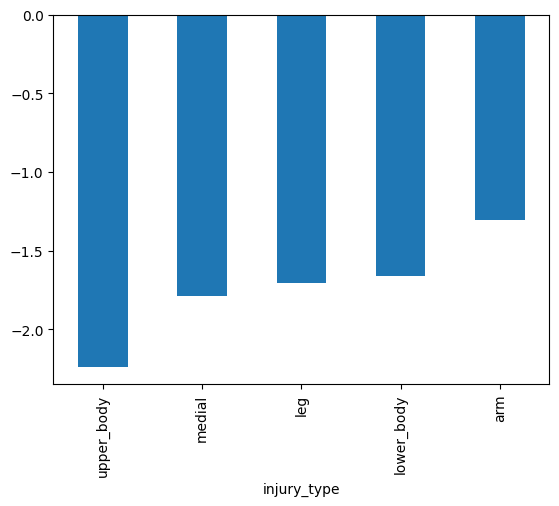

In [ ]:
joined_broadly.groupby("injury_type")["change"].mean().nsmallest(5).plot.bar()

## Prediction Models

The above results are interesting, but is it possible to take our anaylsis one step further and *predict* the impact on an injury on a player's performance? Let's see.

First, let's drop all the observations that don't include injuries.

In [ ]:
just_injuries = joined.dropna()

Now, let's try to make a prediciton with three features: age, position, and injury type.

In [ ]:
X_train = just_injuries[["Age", "Pos", "injury_type"]]
y_train = just_injuries["change"]

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown ='ignore'), ["Pos", "injury_type"]),
    remainder = "passthrough"
)

pipeline = make_pipeline(ct, LinearRegression())
pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pos', 'injury_type'])])),
                ('linearregression', LinearRegression())])

Then, we can evaluate the test error of our model with an R2 score, which ranges from 0 (worst) to 1 (best).

In [ ]:
scores = cross_val_score(pipeline, X_train,
                         y_train,
                         scoring="r2",
                          cv = 5)

scores.mean()

0.19860303060795437

Unfortunately, this is not a good model. Maybe different parameters will yield a better prediciton?

In [ ]:
X_train = just_injuries[["Age", "length", "injury_type"]]
y_train = just_injuries["change"]

ct2 = make_column_transformer(
    (OneHotEncoder(handle_unknown ='ignore'), ["length", "injury_type"]),
    remainder = "passthrough"
)

pipeline2 = make_pipeline(ct2, LinearRegression())
pipeline2.fit(X=X_train, y=y_train)

scores2 = cross_val_score(pipeline2, X_train, y_train, scoring = "r2",
                            cv = 5)

scores2.mean()

0.19698686081976674

These parameters resulted in practically the same score. Perhaps a different regression altogether would perform better? Let's try KNearestNeighbors, iterating through different k values to ensure we find the best one.

In [ ]:
ct3 = make_column_transformer(
    (OneHotEncoder(handle_unknown ='ignore'), ["length", "injury_type"]),
    remainder = "passthrough"
)

for k in range(10, 30):
  pipeline = make_pipeline(ct3, KNeighborsRegressor(k))
  pipeline.fit(X=X_train, y=y_train)

  scores2 = cross_val_score(pipeline, X_train, y_train, scoring = "r2",
                            cv = 5)
  print(scores2.mean())

0.11775189349616451
0.149866649008631
0.14546303719422496
0.16180461073766017
0.17256283022406213
0.16257301017437834
0.18076293656175602
0.18265076888181395
0.1843142943251346
0.19359010850451325
0.2045206680096335
0.2069886631985712
0.20430109702719718
0.20866231883547276
0.2192286138166705
0.21661917696122587
0.22237828598992798
0.2192057096546451
0.22294272868436243
0.21865053090834952


In [ ]:
X_train = just_injuries[["Age", "Pos", "injury_type"]]
y_train = just_injuries["change"]

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown ='ignore'), ["Pos", "injury_type"]),
    remainder = "passthrough"
)

for k in range(10, 30):
  pipeline = make_pipeline(ct, KNeighborsRegressor(k))
  pipeline.fit(X=X_train, y=y_train)

  scores = cross_val_score(pipeline, X_train,
                         y_train,
                         scoring="r2",
                          cv = 5)

  print(scores.mean())

0.2094959018357744
0.2237621606727352
0.21809259037270617
0.22613548877640385
0.22727416026424369
0.22706943709287666
0.23435392043177874
0.22659739130191808
0.22750216034621293
0.23561469408004979
0.22963758990002286
0.23482074046005433
0.2247486772492739
0.23367934365096624
0.23163764548592666
0.23332727660475455
0.2240477956566899
0.22937696360380863
0.2287290110649738
0.22600782144449516


The best k-values yielded marginal improvement, but our model is still lackluster with both sets of parameters. Let's see if we can improve by using the broader categorization of injuries to predict impact.

In [ ]:
joined_broadly = joined_broadly.dropna()

In [ ]:
# have to break it up in order to really test it, right?
X_train = joined_broadly[["Age", "Pos", "injury_type"]]
y_train = joined_broadly["change"]

# first, no scaling
ct = make_column_transformer(
    (OneHotEncoder(), ["injury_type", "Pos"]),
    remainder = "passthrough"
)

pipeline = make_pipeline(ct, LinearRegression())
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline, X_train, y_train, scoring = "r2",
                            cv = 5)

scores.mean()

0.24473554846367626

Broader categorization resulted in a slightly better Linear prediction model. What about with KNeighbors?

In [ ]:
# first, no scaling
ct2 = make_column_transformer(
    (OneHotEncoder(), ["injury_type", "Pos"]),
    remainder = "passthrough"
)

for k in range(10, 30):
  pipeline2 = make_pipeline(ct2, KNeighborsRegressor(k))
  pipeline2.fit(X=X_train, y=y_train)

  scores2 = cross_val_score(pipeline2, X_train, y_train, scoring = "r2",
                            cv = 5)

  print(scores2.mean())

0.20724442726514652
0.21367282595731485
0.2158370817650243
0.22084669393555934
0.2240637853288734
0.2300328129177743
0.22825312858595645
0.23311073017010947
0.2357352575360257
0.2388724694938893
0.23141131183791686
0.24120898986294673
0.23836061385790766
0.24628684239110932
0.2436795904259279
0.2415173175827184
0.24163574218717843
0.2439891030896532
0.2430117672968354
0.2425854321779311


Unfortunately, the KNeighbors model is worse than the Linear model.
What about a different model altogether?

In [ ]:
from sklearn.linear_model import RidgeCV # Ridge regression with built-in cross-validation.

pipeline = make_pipeline(ct, RidgeCV())
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline, X_train, y_train, scoring = "r2",
                            cv = 5)

scores.mean()

0.24928132064465708

The RidgeCV model was ***barely better*** than the other two methods used, but it got up to the 0.25 threshold.

It appears as though we cannot accurately predict the impact of injury on player performance. There are several possible reasons for this, including the fact that player performance is not entirely dependent on injury status. While injuries do have an impact on player performance, there are numerous other factors that can change a player's performance, including trades, personel and coaching changes, and playing time reductions. This explanation is compatibile with our models, which are all able to predict some player performance, but not surpass an R2 threshold of about 0.25. Thus, we have come to the conclusion that *it is possible to partially predict the impact of a given injury on player performance, but only about 25%*.

## Conclusion

While it is unfortunate that we were unable to generate an accurate prediction model, we are pleased that we could answer all of the questions posed at the beginning of the investigation. Moreoever, we were able to come to the very interesting conclusion that rib injuries have the greatest impact on player performance, with support from both methods of classifcation. Thus, overall, we consider this notebook to be a success.

This project was also a good learning experience, as it taught us about the importance of clear commuication. While working, there were times when the next steps were unclear. However, regular progress reports that outlined what had already been done and what had yet to be done were really helpful in organizing the entire process.

Moving forward, this notebook could be improved by including more performance and injury data. Including all seasons from 2000 to the present day would  more than double the number of injuries in our dataset and allow us to make stronger conclusions. Furthemore, including this data could allow us to generate a good prediction model. However, we are not sure that a truly accurate model is possible, given our bounded R2 score and the number of factors that impact player performance. Ultimately, it could just be that the career-wide implacations of injury on player performance are simply unpredictable past a 25% threshold.

## Notes

**Note 1**

While Overall Performance is simple and covers all of the major player attributes,
it fails to take into account the effect that a player may have on the performance
of his team. However, doing this would require data about team performance both
with and without that player, which we don't have. Thus, while this statistic
may not be a good indication of how "valuable" a player is to his team, it does do
a roughly good job of evaluating his individual performance, which is exactly
what we need. Furthermore, a ranking of the top players by OP shows
who would generally be considered the best players of the league, indiciating that
OP is, at some general level, correct.

In [ ]:
joined["OP"].nlargest(20)

name                   Year     
Russell Westbrook      2016-2017    32.971100
James Harden           2018-2019    32.157333
                       2016-2017    31.736540
                       2019-2020    31.115945
Giannis Antetokounmpo  2018-2019    30.420794
Stephen Curry          2015-2016    30.047474
Giannis Antetokounmpo  2019-2020    29.741866
LeBron James           2017-2018    29.406008
Kevin Durant           2013-2014    29.383922
Luka Dončić            2019-2020    29.126136
James Harden           2017-2018    28.863333
Joel Embiid            2018-2019    28.422256
Kevin Durant           2015-2016    28.278867
Karl-Anthony Towns     2019-2020    28.262615
LeBron James           2012-2013    28.063800
Damian Lillard         2019-2020    27.897015
Anthony Davis          2018-2019    27.890600
                       2017-2018    27.825150
Kevin Love             2013-2014    27.665586
Karl-Anthony Towns     2018-2019    27.516820
Name: OP, dtype: float64

**Note 2**

Past season start and end times, sourced from Wikipedia:

'10-'11

*   start: 10-26-2010
*   end: 06-12-2011

'11-'12 (season shortened due to bargaining agreement)

*   start: 12-26-2011
*   end: 06-21-2012

'12-'13

*   start: 10-30-2012
*   end: 06-20-2013

'13-'14

*   start: 10-29-2013
*   end: 06-15-2014

'14-'15

*   start: 10-28-2014
*   end: 06-16-2015

'15-'16

*   start: 10-27-2015
*   end: 06-19-2016

'16-'17

*   start: 10-25-2016
*   end: 06-12-2017

'17-'18

*   start: 10-17-2017
*   end: 06-08-2018

'18-'19

*   start: 10-16-2018
*   end: 06-13-2019

'19-'20 (season lengthened due to COVID disruption)

*   start: 10-22-2019
*   end: 10-11-2020